In [56]:
from sparse_ffn.moe import MoE
from sparse_ffn.controller import ControllerFFN
from sparse_ffn.pkm import PKM
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
baseline = nn.Sequential(nn.Linear(256,4096), nn.GELU(), nn.Linear(4096,256))
moe = MoE(256,1023,4,2)
cnt = ControllerFFN(256,126, 4032,32)
pkm = PKM(256,1024,56,28,4)

In [21]:
models = {
    "Baseline": nn.Sequential(nn.Linear(256,4096), nn.GELU(), nn.Linear(4096,256)),
    "MoE ($k=1$)": MoE(256,1023,4,1),
    "MoE ($k=2$)": MoE(256,1023,4,2),
    "MoE ($k=3$)": MoE(256,1023,4,3),
    "CNT ($N=16$)": ControllerFFN(256,248, 3968, 16),
    "CNT ($N=32$)": ControllerFFN(256,126, 4032, 32),
    "CNT ($N=64$)": ControllerFFN(256,63, 4032, 64),
    "PKM ($k=14$)": PKM(256,1024,56,14,4),
    "PKM ($k=28$)": PKM(256,1024,56,28,4),
    "PKM ($k=42$)": PKM(256,1024,56,42,4),
}

In [59]:
def inference_time(model, warmup=100, reps=1000, batch_size=16, context_length=256,dim_in=256,seed=123):
    torch.manual_seed(seed)
    device = torch.device("cuda")
    model.to(device)
    dummy_input = torch.randn(batch_size,context_length,dim_in, dtype=torch.float).to(device)
    
    # INIT LOGGERS
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings=torch.zeros(reps)
    #GPU-WARM-UP
    for _ in range(warmup):
        _ = model(dummy_input)
    # MEASURE PERFORMANCE
    with torch.no_grad():
        for rep in range(reps):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time
    return timings

In [61]:
results = [(name, inference_time(m).numpy()) for name, m in models.items()]

In [70]:
df_list = []
for name, ts in results:
    mean = np.mean(ts)
    std = np.std(ts)
    df_list.append((name, mean, std))

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(df_list, columns=['Model', 'Mean (ms)', 'Standard Deviation (ms)'])
print(df.to_latex(index=False,float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
Model & Mean (ms) & Standard Deviation (ms) \\
\midrule
Baseline & 12.83 & 0.10 \\
MoE ($k=1$) & 16.14 & 0.07 \\
MoE ($k=2$) & 16.24 & 0.08 \\
MoE ($k=3$) & 16.45 & 0.17 \\
CNT ($N=16$) & 34.42 & 0.09 \\
CNT ($N=32$) & 33.92 & 0.09 \\
CNT ($N=64$) & 34.06 & 0.25 \\
PKM ($k=14$) & 43.79 & 1.30 \\
PKM ($k=28$) & 77.35 & 3.00 \\
PKM ($k=42$) & 117.48 & 0.04 \\
\bottomrule
\end{tabular}



In [27]:
names = [n for n in models.keys()]
timings = [inference_time(m) for m in models.values()]

In [30]:
timings = [t.numpy() for t in timings]

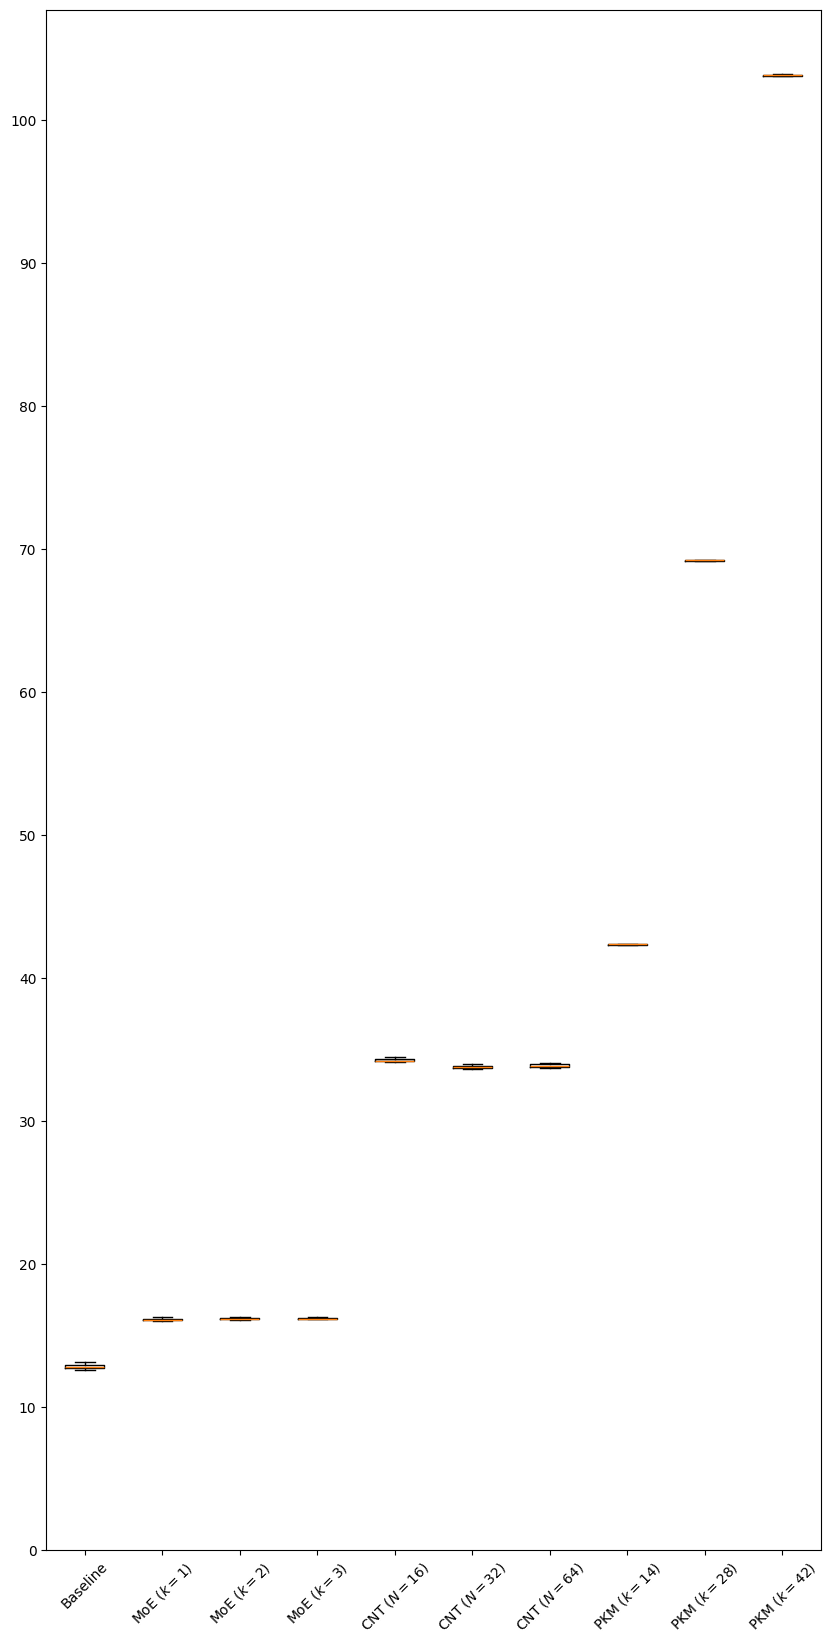

In [51]:
plt.figure(figsize=(10,20))
plt.boxplot(timings,vert=True,showfliers=False)
plt.yticks(np.linspace(0,100,num=11))
plt.xticks(ticks=np.arange(1,len(timings)+1),labels=names, rotation=45)

plt.show()